In [1]:
import math
import matplotlib.pyplot as plt
import random
import time
import copy

In [64]:
def get_some_randomness(l, r, elems):
    indexes=list(range(l, r))
    random.shuffle(indexes)
    return indexes[:elems]

class Vertex:
    def __init__(self, v, preve=-1, nexte=-1):
        self.value=v
        self.present=False
        if preve!=-1:
            self.present=True
        self.prev=preve
        self.next=nexte
        
    def exchange(self, preve, nexte):
        self.present=False
        if preve!=-1:
            self.present=True
        self.prev=preve
        self.next=nexte
            
    def check_consistency(self, vertexes):
        if not self.present:
            return
        if not vertexes[self.prev].next==self.value or not vertexes[self.next].prev==self.value:
            print(f"DUPA {self.value}")
    
    def __str__(self):
        return f'{self.value}: <{self.prev}, {self.next}>'
                

class Pathway:
    def _greedy_closest_neigh_comparer(self, last, start, cur, compared):
        if self.matrix[last][compared]<self.matrix[last][cur]:
            return True
        return False
    
    def _greedy_cycle_comparer(self, last, start, cur, compared):
        if self.matrix[last][compared]+self.matrix[start][compared]<self.matrix[last][cur]+self.matrix[start][cur]:
            return True
        return False

    def _double_regret(self, pathway, j, k=2, cnst=1):
        regrets=[]
        ln=len(pathway)
        for i in range(0, ln):
            v1=pathway[i]
            v2=pathway[(i+1)%ln]
            regrets.append((self.matrix[v1][j]+self.matrix[v2][j]-self.matrix[v1][v2], i))
        regrets=sorted(regrets, key=lambda x: x[0])

        sum_of_regrets=-cnst*regrets[0][0]#-regrets[0][0]
        for i in range(1, min(ln, k)):
            sum_of_regrets=sum_of_regrets+regrets[i][0]-regrets[0][0]
        return sum_of_regrets, regrets[0][1]+1


    def _general_heuristic(self, start, comparer, regrets=False, k_reg=2, cnst=1):
        ln=len(self.matrix)//2
        allez=len(self.matrix)
        last, elems, cur, path, devoured=start, 1, -1, [start], [0]*allez
        devoured[start]=1
        fortress_of_regrets=[0, -1]

        while len(path)<ln:
            for j in range(allez):
                if devoured[j]==1:
                    continue

                if regrets==True:
                    partial_regret=comparer(path, j, k_reg, cnst)
                    if cur==-1 or partial_regret[0]>fortress_of_regrets[0]:
                        fortress_of_regrets=partial_regret
                        cur=j
                if regrets==False and (cur==-1 or comparer(last, path[0], cur, j)):
                    cur=j

            last, cur=cur, -1
            devoured[last]=1
            if regrets==False:
                path.append(last)
            else:
                path.insert(fortress_of_regrets[1], last)
            fortress_of_regrets=[0, -1]
        return path
    
    def _vertex_list_to_path(self):
        ln=self.halfway
        path=[]
        for i in range(len(self.matrix)):
            if self.vertexes[i].present==False:
                continue
            j=self.vertexes[i].next
            
            path=[i, j]
            while self.vertexes[j].next!=i:
                #print(f'ideal: {i}, preve: {self.vertexes[j].prev}, zis: {j}, nexte: {self.vertexes[j].next}')
                if self.vertexes[j].next!=j:
                    j=self.vertexes[j].next
                else:
                    j=self.vertexes[j].prev
                path.append(j)
        return path
    
    def _path_to_vertex_list(self):
        ln=self.halfway
        vertexes=[]
        for i in range(len(self.matrix)):
            d=Vertex(i)
            vertexes.append(d)
            
        for i, x in enumerate(self.pathway):
            d=Vertex(x, self.pathway[(i-1)%ln], self.pathway[(i+1)%ln])
            vertexes[x]=d
        return vertexes
    
    
    
    
    
    
    
    
    
    
    
    #Indexes, indexes everywhere; returns literal cost (negata - profit)
    def _cost_swap_vertex(self, v1, v2):
        #closer
        if self.vertexes[v1].present and self.vertexes[v2].present and (self.vertexes[v2].prev==v1 or self.vertexes[v2].next==v1):
            if self.vertexes[v2].next==v1: #v1->v2 must be
                tmp=v2
                v2=v1
                v1=v2
            prev1=self.vertexes[v1].prev
            next2=self.vertexes[v2].next
            neue=self.matrix[v1][next2]+self.matrix[v2][prev1]
            eld= self.matrix[v2][next2]+self.matrix[v1][prev1]
            return eld-neue
        
        #Not so close
        if self.vertexes[v1].present and self.vertexes[v2].present:
            prev1=self.vertexes[v1].prev
            next1=self.vertexes[v1].next

            prev2=self.vertexes[v2].prev
            next2=self.vertexes[v2].next
            neue=self.matrix[v1][prev2]+self.matrix[v1][next2]+self.matrix[v2][prev1]+self.matrix[v2][next1]
            eld= self.matrix[v2][prev2]+self.matrix[v2][next2]+self.matrix[v1][prev1]+self.matrix[v1][next1]
            return eld-neue
        
        #only one present
        if self.vertexes[v2].present: #And its v1 present
            tmp=v1
            v1=v2
            v2=tmp
        prev1=self.vertexes[v1].prev
        next1=self.vertexes[v1].next
        
        eld= self.matrix[v1][prev1]+self.matrix[v1][next1]-self.matrix[prev1][next1]
        neue=self.matrix[v2][prev1]+self.matrix[v2][next1]-self.matrix[prev1][next1]
        
        
        for i in range(100):
            if self.vertexes[i].present==False or i==prev1 or i==v1:
                continue
            nel=self.vertexes[i].next
            if self.matrix[v2][i]+self.matrix[v2][nel]-self.matrix[i][nel]<neue:
                neue=self.matrix[v2][i]+self.matrix[v2][nel]-self.matrix[i][nel]
        return eld-neue
    
    #Swap v1, v2 with one outside
    def _swap_partial(self, v1, v2):
        if self.vertexes[v2].prev==-1: #v2 exists always
            tmp=v2
            v2=v1
            v1=tmp
        prev2=self.vertexes[v2].prev
        next2=self.vertexes[v2].next
        
        self.vertexes[v2].exchange(-1, -1)
        self.vertexes[next2].prev=prev2
        self.vertexes[prev2].next=next2
        
        
        neue=1000000000000
        for i in range(100):
            if self.vertexes[i].present==False:
                continue
            nel=self.vertexes[i].next
            if self.matrix[v1][i]+self.matrix[v1][nel]-self.matrix[i][nel]<neue:
                neue, place=self.matrix[v1][i]+self.matrix[v1][nel]-self.matrix[i][nel], i
        
        nel=self.vertexes[place].next
        self.vertexes[place].next=v1
        self.vertexes[nel].prev=v1
        self.vertexes[v1].exchange(place, nel)
        
    def _swap_nearby(self, v1, v2):
        if self.vertexes[v2].next==v1: #v1->v2 must be
            tmp=v2
            v2=v1
            v1=v2
        prev1=self.vertexes[v1].prev
        next2=self.vertexes[v2].next
        
        self.vertexes[next2].prev=v1
        self.vertexes[prev1].next=v2
        self.vertexes[v2].exchange(prev1, v1)
        self.vertexes[v1].exchange(v2, next2)
        
    
    def _swap_by_vertex(self, v1, v2):
        if self.vertexes[v2].prev==-1 or self.vertexes[v1].prev==-1:
            self._swap_partial(v1, v2)
        elif self.vertexes[v2].prev==v1 or self.vertexes[v2].next==v1:
            self._swap_nearby(v1, v2)
        
        else:
            prev1=self.vertexes[v1].prev
            next1=self.vertexes[v1].next
            prev2=self.vertexes[v2].prev
            next2=self.vertexes[v2].next

            self.vertexes[next2].prev=v1
            self.vertexes[next1].prev=v2
            self.vertexes[prev2].next=v1
            self.vertexes[prev1].next=v2
            self.vertexes[v2].exchange(prev1, next1)
            self.vertexes[v1].exchange(prev2, next2)
    
    
    #Next edge after vertex swapped
    def _cost_swap_edges(self, v1, v2):
        if self.vertexes[v2].prev==v1 or self.vertexes[v2].next==v1:
            return -1
        next1=self.vertexes[v1].next
        next2=self.vertexes[v2].next
        
        neue=self.matrix[v2][v1]+self.matrix[next1][next2]
        eld= self.matrix[v2][next2]+self.matrix[v1][next1]
        return eld-neue
        
    def _swap_by_edge(self, v1, v2):
        next1=self.vertexes[v1].next
        next2=self.vertexes[v2].next
        
        j=next1
        while j!=next2:
            tmp=self.vertexes[j].prev
            self.vertexes[j].prev=self.vertexes[j].next
            self.vertexes[j].next=tmp
            j=self.vertexes[j].prev
        
        self.vertexes[next1].next=next2
        self.vertexes[next2].prev=next1
        
        self.vertexes[v1].exchange(self.vertexes[v1].prev, v2)
        self.vertexes[v2].exchange(v1, self.vertexes[v2].next)
        
    def _get_properties(self, i, j, edgy):
        if i==j or (not self.vertexes[i].present and not self.vertexes[j].present):
            return -1, -1
        if not self.vertexes[i].present or not self.vertexes[j].present or edgy==0:
            coste=self._cost_swap_vertex(i, j)
            return coste, self._swap_by_vertex
        elif edgy==1:
            coste=self._cost_swap_edges(i, j)
            return coste, self._swap_by_edge
        else:
            coste1=self._cost_swap_vertex(i, j)
            coste2=self._cost_swap_edges(i, j)
            if coste1>coste2:
                return coste1, self._swap_by_vertex
            return coste2, self._swap_by_edge
            
    def steep(self, edgy=0):
        while True:
            max_gain=0
            for i in range(len(self.matrix)):
                for j in range(i+1, len(self.matrix)):
                    coste, fun=self._get_properties(i, j, edgy)
                    
                    if coste<max_gain:
                        continue
                    max_gain=coste
                    vals=[fun, i, j]
                    
            if max_gain<=0:
                return
            self.current_cost-=max_gain
            max_gain=0
            vals[0](vals[1], vals[2])
            
    def greed(self, edgy=0):
        while True:
            changed=False
            rn1=get_some_randomness(1, len(self.matrix), len(self.matrix))
            rn2=get_some_randomness(1, len(self.matrix), len(self.matrix))
            max_gain=0
            
            for i in rn1:
                for j in rn2:
                    if j>=i:
                        continue
                    coste, fun=self._get_properties(i, j, edgy)
                    if coste<=0:
                        continue
                    changed=True
                    self.current_cost-=coste
                    fun(i, j)
            if changed==False:
                return
    
    def execute_optimizer(self, name, params):
        _methods={
            'greed':self.greed,
            'steep':self.steep
        }
        _methods[name](*params)
        self.pathway=self._vertex_list_to_path()
    
    def cost(self):
        ln=self.halfway
        summa=0
        for i,x in enumerate(self.pathway):
            summa+=self.matrix[x][self.pathway[(i+1)%ln]]
        return summa
    
    
    def __init__(self, matrix, constr_method_and_args, start):
        _methods={
            'greedy closest neigh':self._greedy_closest_neigh_comparer,
            'greedy cycle':self._greedy_cycle_comparer,
            'k regret':self._double_regret,
            'random':'random'
        }
        self.halfway=len(matrix)//2
        
        self.matrix=matrix
        method=_methods[constr_method_and_args[0]]
        if  method=='random':
            self.pathway=get_some_randomness(1, len(matrix), self.halfway)
        else:
            self.pathway=self._general_heuristic(start, method, *constr_method_and_args[1:])
        self.current_cost=-1
        self.current_cost=self.cost()
        self.vertexes=self._path_to_vertex_list()
        self.pathway=self._vertex_list_to_path()
            
def read_tsp(filename):
    res=[]
    with open(filename) as falka:
        x=falka.readline()
        while x:
            res.append(x)
            x=falka.readline()
    res=res[6:-1]
    res=[x[:-1].split(' ') for x in res]
    res=[[int(y) for y in x] for x in res]
    return res

def calc_matrix(res):
    C=len(res)
    matrix=[]
    for i in range(C):
        matrix.append([0]*C)

    for i in range(C):
        for j in range(C):
            matrix[i][j]=(res[i][1]-res[j][1])*(res[i][1]-res[j][1])+(res[i][2]-res[j][2])*(res[i][2]-res[j][2])
            matrix[i][j]=round(math.sqrt(matrix[i][j]))
    return matrix

def systematize(file_namez):
    properties={}
    for value in file_namez:
        x=file_namez[value]
        properties[x]={}
        properties[x]['res']=read_tsp(value)
        properties[x]['matrix']=calc_matrix(properties[x]['res'])
    return properties

    
file_namez={'../kroA100.tsp':'kroA100.tsp', '../kroB100.tsp':'kroB100.tsp'}
properties=systematize(file_namez)

In [65]:
#reality=[('greed', ['greedy closest neigh']), ('cycle', ['greedy cycle']), 
#        ('2reg-1', ['k regret', True, 2, 0]), ('2reg-2', ['k regret', True, 2, 1]), ('random', ['random'])]

Inf=1000000000
def append_starter(dct, res, iters, name='res'):
    dct['min_'+name]=min(dct['min_'+name], res)
    dct['max_'+name]=max(dct['max_'+name], res)
    dct['avg_'+name]=res/iters+dct['avg_'+name]
    
def append_later(dct, res, path, zeit, iters):
    if res<dct['min_res']:
        dct['path']=path
    append_starter(dct, res, iters)
    append_starter(dct, zeit, iters, 'time')
    
def create_fields(dct, elem, namez):
    dct[elem]={}
    for x in namez:
        dct[elem]['min_'+x]=Inf
        dct[elem]['max_'+x]=0
        dct[elem]['avg_'+x]=0

post_reality=[('random', ['random']), ('2reg-2', ['k regret', True, 2, 1])]
reality=[('steep, swap vertexes', ['steep', 0]), ('steep, swap edges', ['steep', 1]), 
         ('steep, swap both', ['steep', 2]), ('greed, swap vertexes', ['greed', 0]),
         ('greed, swap edges', ['greed', 1]), ('greed, swap both', ['greed', 2])]

max_zeit=0
system={}
system_starter={}

iters=100
for falka in range(iters):
    print(f'iteracja nr {falka}')
    for x in properties:
        matrix=properties[x]['matrix']
        for alpha in post_reality:
            ts=time.time()
            if alpha[0]=='random':
                basic_path=Pathway(matrix, alpha[1], -1)
            else:
                basic_path=-1
                for i in range(len(matrix)):
                    some_neo_path=Pathway(matrix, alpha[1], i)
                    if basic_path==-1 or some_neo_path.cost()<basic_path.cost():
                        basic_path=some_neo_path
                        
            t_all=time.time()-ts
            if (x, alpha[0]) not in system_starter:
                create_fields(system_starter, (x, alpha[0]), ['res'])
            append_starter(system_starter[(x, alpha[0])], basic_path.cost(), iters)

            for y in reality:
                if (x, alpha[0], y[0]) not in system:
                    create_fields(system, (x, alpha[0], y[0]), ['res', 'time'])

                some_path=copy.deepcopy(basic_path)
                t1=time.time()
                some_path.execute_optimizer(y[1][0], y[1][1:])
                way=some_path.pathway
                t2=time.time()-t1+t_all
                if(t2>max_zeit):
                    max_zeit=t2

                append_later(system[(x, alpha[0], y[0])], some_path.cost(), some_path.pathway, t2, iters)

iteracja nr 0
iteracja nr 1
iteracja nr 2
iteracja nr 3
iteracja nr 4
iteracja nr 5
iteracja nr 6
iteracja nr 7
iteracja nr 8
iteracja nr 9
iteracja nr 10
iteracja nr 11
iteracja nr 12
iteracja nr 13
iteracja nr 14
iteracja nr 15
iteracja nr 16
iteracja nr 17
iteracja nr 18
iteracja nr 19
iteracja nr 20
iteracja nr 21
iteracja nr 22
iteracja nr 23
iteracja nr 24
iteracja nr 25
iteracja nr 26
iteracja nr 27
iteracja nr 28
iteracja nr 29
iteracja nr 30
iteracja nr 31
iteracja nr 32
iteracja nr 33
iteracja nr 34
iteracja nr 35
iteracja nr 36
iteracja nr 37
iteracja nr 38
iteracja nr 39
iteracja nr 40
iteracja nr 41
iteracja nr 42
iteracja nr 43
iteracja nr 44
iteracja nr 45
iteracja nr 46
iteracja nr 47
iteracja nr 48
iteracja nr 49
iteracja nr 50
iteracja nr 51
iteracja nr 52
iteracja nr 53
iteracja nr 54
iteracja nr 55
iteracja nr 56
iteracja nr 57
iteracja nr 58
iteracja nr 59
iteracja nr 60
iteracja nr 61
iteracja nr 62
iteracja nr 63
iteracja nr 64
iteracja nr 65
iteracja nr 66
itera

In [73]:
#Wyznaczenie baseline patha dla każdej instancji
for x in properties:
    max_zeit=max([system[y]['avg_time'] for y in system if y[0]==x])
    print(f'Maksymalny średni czas: {max_zeit}')
    
    t1=time.time()
    zeit, cur_cost, amount=0, 10000000000, 0
    proper_path=-1
    while zeit<max_zeit:
        basic_path=Pathway(matrix, post_reality[0][1], -1)
        b_cost=basic_path.cost()
        if proper_path==-1 or b_cost<cur_cost:
            cur_cost=b_cost
            proper_path=basic_path
        amount+=1
        zeit=time.time()-t1
        
    properties[x]['bare_path']=proper_path
    print(f'koszt: {cur_cost}, liczba testowanych rozwiązań: {amount}')

Maksymalny średni czas: 4.279751808643341
koszt: 61100, liczba testowanych rozwiązań: 5851
Maksymalny średni czas: 4.1801724433898935
koszt: 61793, liczba testowanych rozwiązań: 5683


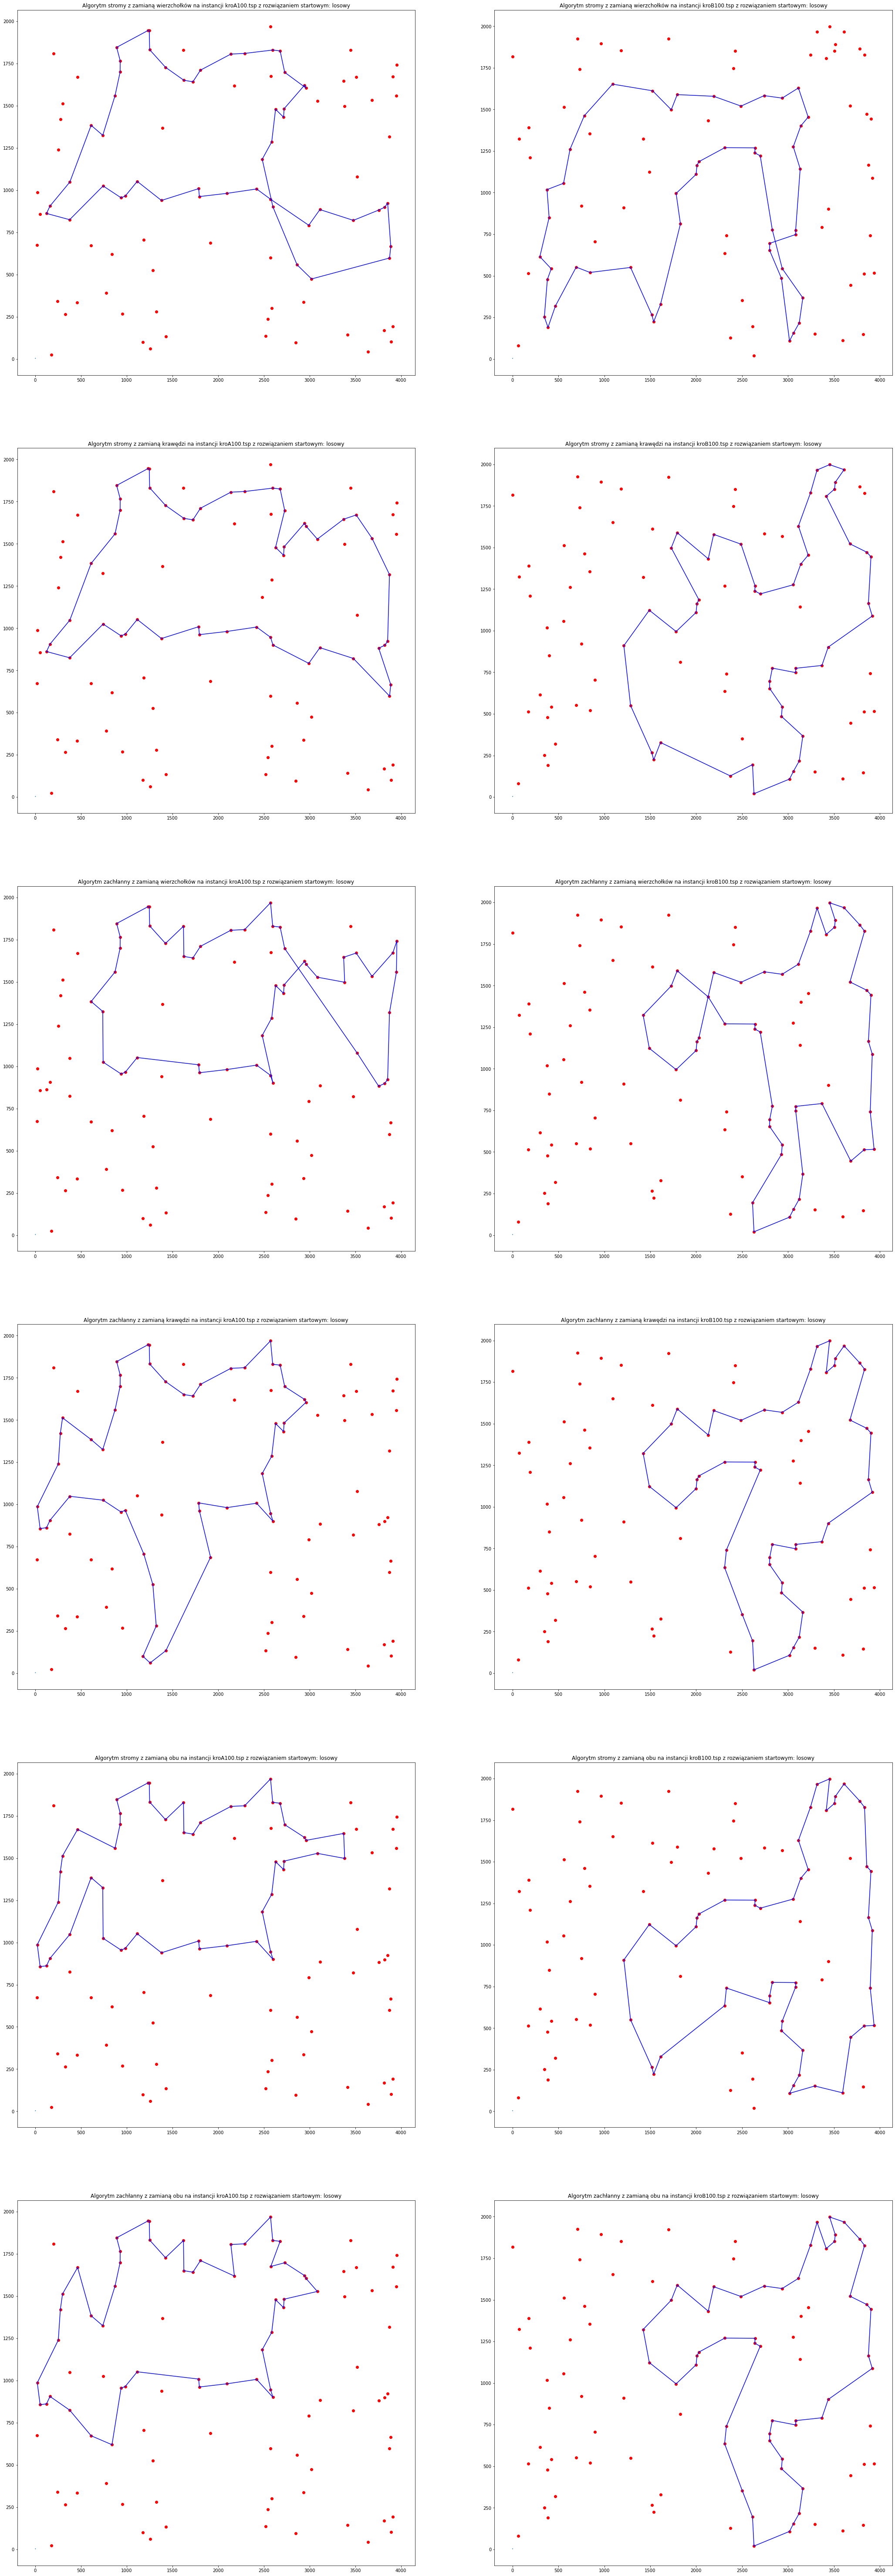

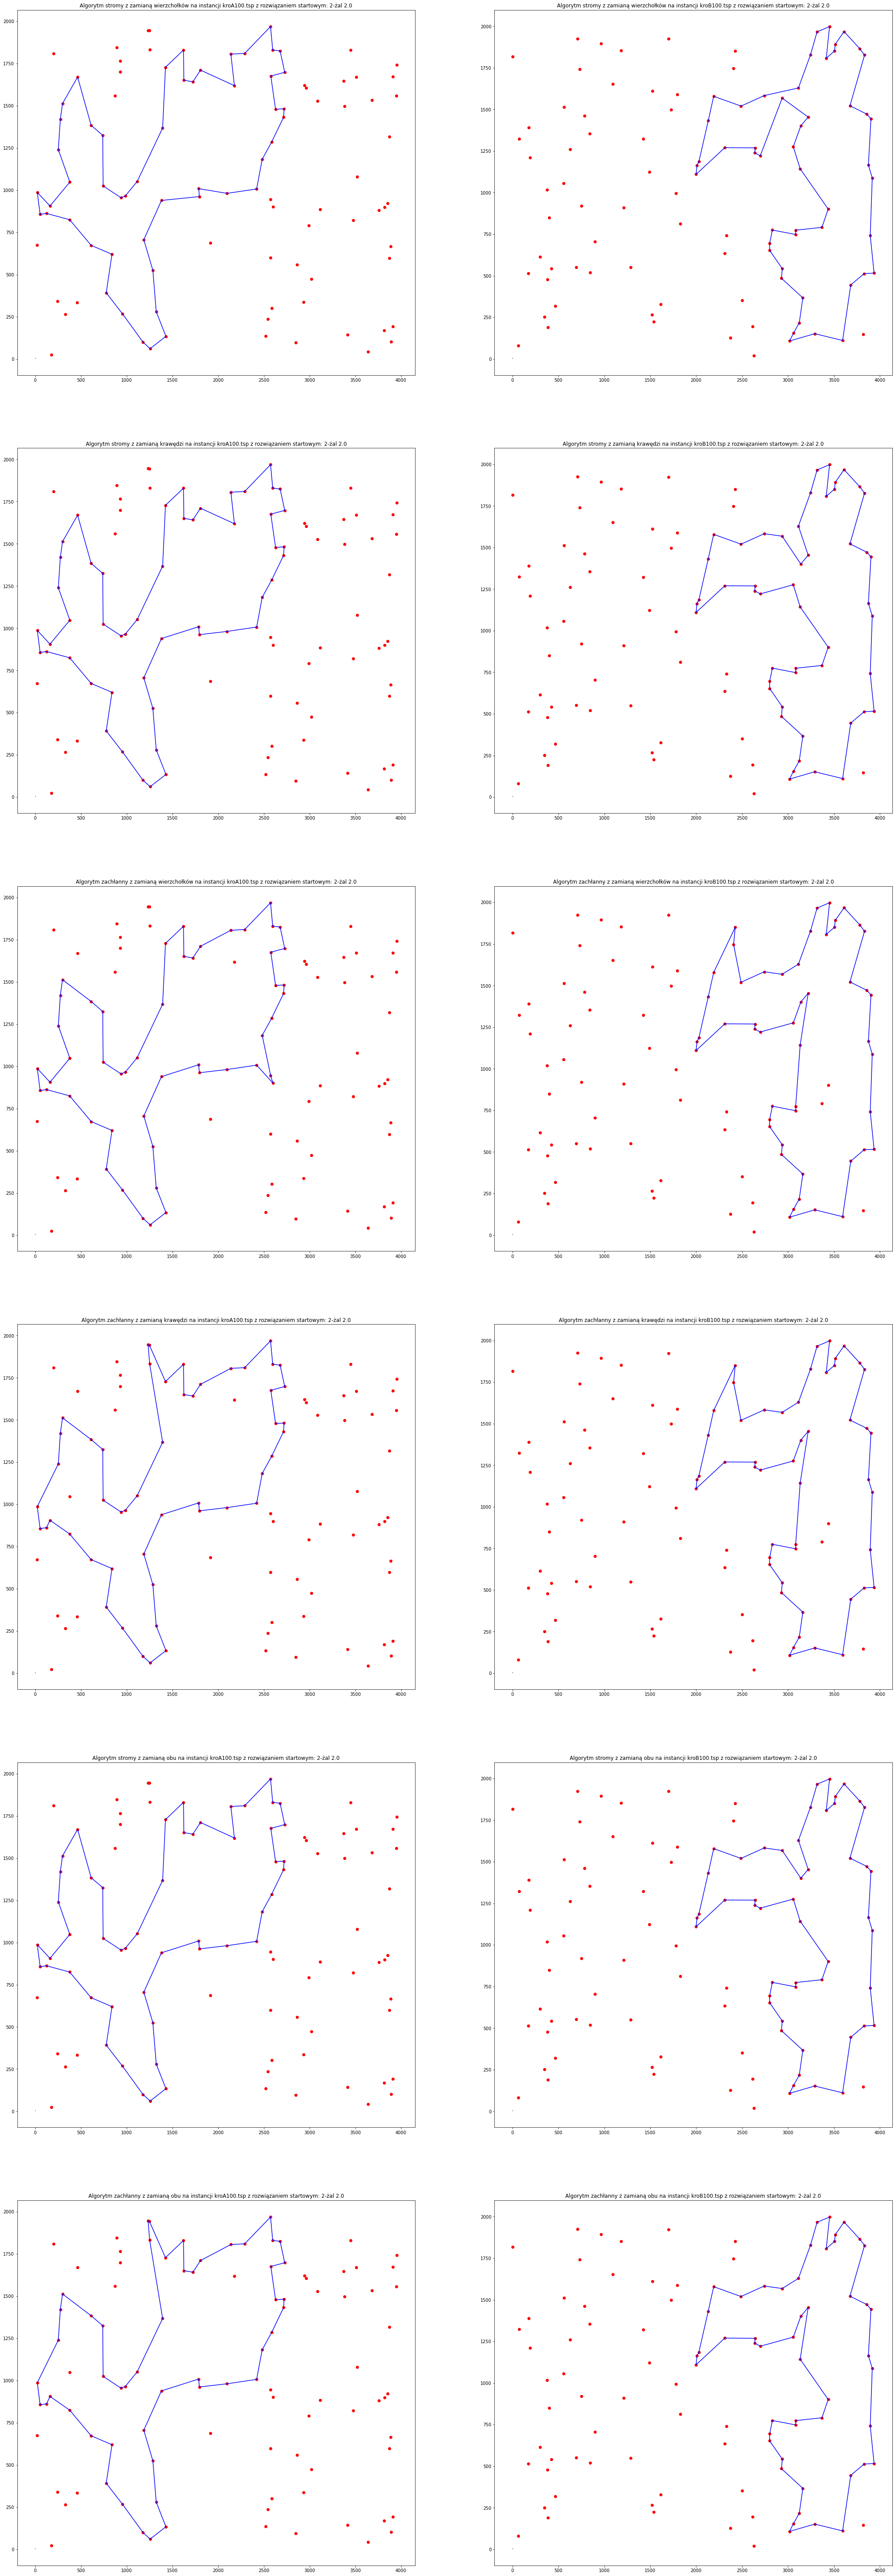

In [67]:
def print_map(res, path, ax):
    ax.plot([1,2], [3,4])
    ln=len(path)
    for x, v1 in enumerate(path):
        v2=path[(x+1)%ln]
        ax.plot([res[v1][1], res[v2][1]], [res[v1][2], res[v2][2]], color='blue')
    ax.scatter([x[1] for x in res], [x[2] for x in res], color='red')

mapp={'kroA100.tsp':0, 'kroB100.tsp':1, 'steep, swap vertexes':0, 'steep, swap edges':1, 
     'greed, swap vertexes':2, 'greed, swap edges':3, 'steep, swap both':4, 'greed, swap both': 5, 
     'random':0, '2reg-2':1}

naming={'steep, swap vertexes':'stromy z zamianą wierzchołków', 'steep, swap edges':'stromy z zamianą krawędzi', 
     'greed, swap vertexes':'zachłanny z zamianą wierzchołków', 'greed, swap edges':'zachłanny z zamianą krawędzi', 
       'steep, swap both':'stromy z zamianą obu', 'greed, swap both':'zachłanny z zamianą obu', 
       'random':'losowy', '2reg-2':'2-żal 2.0'}

all_solutions=len(reality)

for y in post_reality:
    typic=18
    plots=len(reality)
    fig, ax=plt.subplots(plots, 2, figsize=(2*typic, plots*typic))
    if plots==1:
        ax=[ax]
        
    for x in system:
        if x[1]!=y[0]:
            continue
        col=mapp[x[0]]
        row=mapp[x[2]]
        print_map(properties[x[0]]['res'], system[x]['path'], ax[row][col])
        ax[row][col].set_title(f'Algorytm {naming[x[2]]} na instancji {x[0]} z rozwiązaniem startowym: {naming[x[1]]}')
    plt.savefig(f"heury_{y[0]}.svg", bbox_inches="tight")

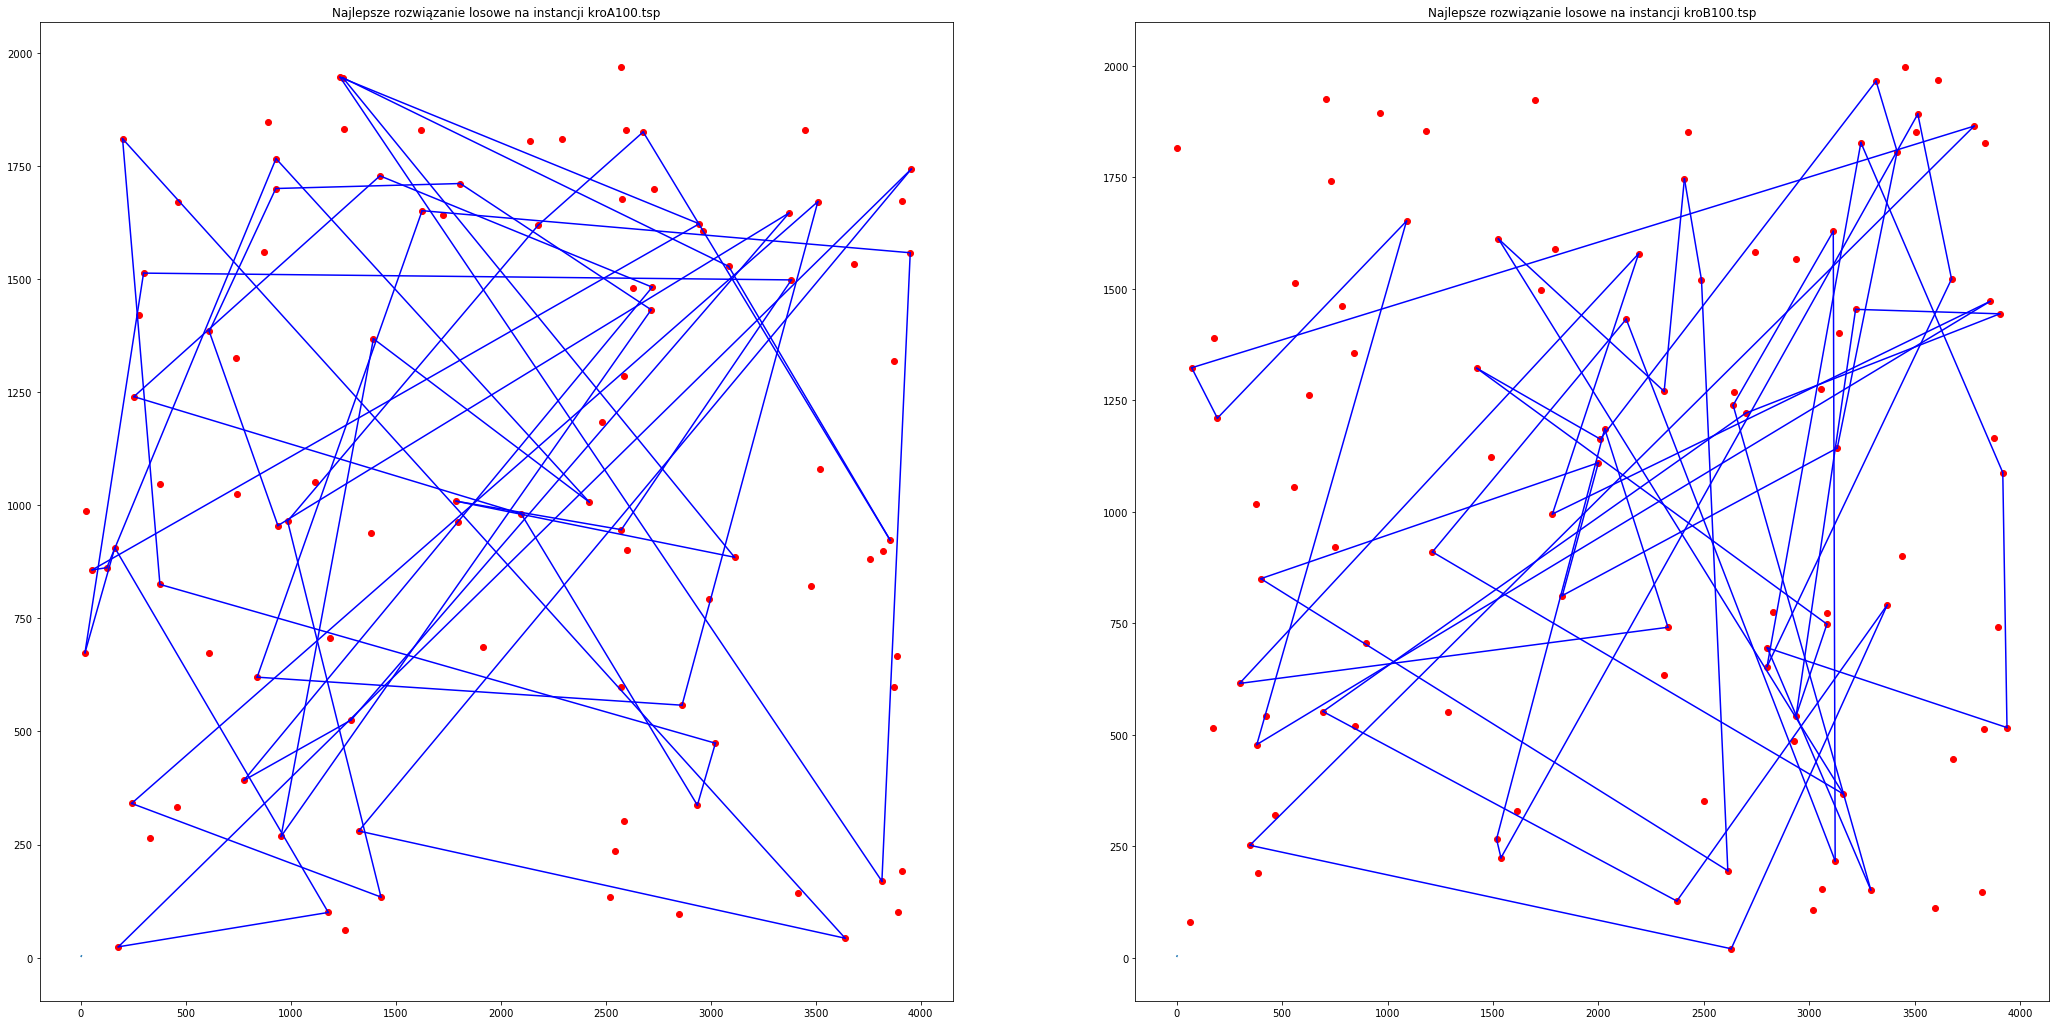

In [68]:
typic=18
fig, ax=plt.subplots(1, 2, figsize=(2*typic, typic))
for i, x in enumerate(properties):
    print_map(properties[x]['res'], properties[x]['bare_path'].pathway, ax[i])
    ax[i].set_title(f'Najlepsze rozwiązanie losowe na instancji {x}')
plt.savefig(f"bieda_heury.svg")

In [72]:
neo_naming={
    'steep, swap vertexes':('stromy', 'wierzchołki'), 'steep, swap edges':('stromy', 'krawędzie'), 
    'greed, swap vertexes':('zachłanny', 'wierzchołki'), 'greed, swap edges':('zachłanny', 'krawędzie'), 
    'steep, swap both':('stromy', 'obydwa'), 'greed, swap both':('zachłanny', 'obydwa'), 
}

for x in system:
    print(f'{x[0]} & {neo_naming[x[2]][0]} & {neo_naming[x[2]][1]} & {naming[x[1]]}', end='')
    for y in system[x]:
        if y!='path':
            print(f' & {system[x][y]:.2f}', end='')
    print('\\\\ \\hline')

kroA100.tsp & stromy & wierzchołki & losowy & 10701.00 & 16989.00 & 13508.05 & 3.17 & 5.91 & 4.28\\ \hline
kroA100.tsp & stromy & krawędzie & losowy & 10149.00 & 12545.00 & 11143.81 & 3.09 & 4.80 & 3.65\\ \hline
kroA100.tsp & stromy & obydwa & losowy & 9699.00 & 12388.00 & 11176.17 & 2.98 & 4.69 & 3.74\\ \hline
kroA100.tsp & zachłanny & wierzchołki & losowy & 10156.00 & 16227.00 & 12418.49 & 0.18 & 0.67 & 0.30\\ \hline
kroA100.tsp & zachłanny & krawędzie & losowy & 9644.00 & 12303.00 & 10847.28 & 0.13 & 0.46 & 0.28\\ \hline
kroA100.tsp & zachłanny & obydwa & losowy & 9466.00 & 12932.00 & 10861.38 & 0.18 & 0.54 & 0.29\\ \hline
kroA100.tsp & stromy & wierzchołki & 2-żal 2.0 & 10174.00 & 10174.00 & 10174.00 & 3.68 & 4.19 & 3.80\\ \hline
kroA100.tsp & stromy & krawędzie & 2-żal 2.0 & 10163.00 & 10163.00 & 10163.00 & 3.73 & 4.24 & 3.86\\ \hline
kroA100.tsp & stromy & obydwa & 2-żal 2.0 & 10163.00 & 10163.00 & 10163.00 & 3.73 & 4.25 & 3.86\\ \hline
kroA100.tsp & zachłanny & wierzchołki & 2-ż